In [29]:
from langchain.chat_models import init_chat_model
from langgraph.graph import StateGraph
from langgraph.graph import END, START
from langgraph.graph.message import MessagesState
from langgraph.prebuilt import ToolNode, tools_condition
from langchain_core.tools import tool
from langgraph.checkpoint.sqlite import SqliteSaver


import os
import dotenv

dotenv.load_dotenv(dotenv_path="../../.venv")

False

In [30]:
import sqlite3


llm = init_chat_model(
    "ollama:gpt-oss:latest",
    base_url=os.environ.get("OLLAMA_BASE_URL"),
)

sql_connection = sqlite3.connect("memory.db", check_same_thread=False)

In [31]:
class State(MessagesState):
    pass


graph_builder = StateGraph(State)

In [32]:
@tool
def get_weather(city: str):
    """
    Get weather in the city
    """
    return f"The weather in {city} is sunny."


# Explaining and providing information about the available tool to the LLM model
llm_with_tools = llm.bind_tools(tools=[get_weather])


def chatbot(state: State) -> State:
    response = llm_with_tools.invoke(state["messages"])
    return {"messages": [response]}

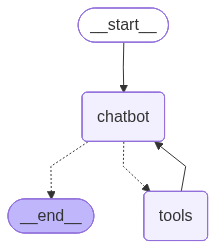

In [33]:
tools = ToolNode(tools=[get_weather])

graph_builder.add_node("chatbot", chatbot)
graph_builder.add_node("tools", tools)

graph_builder.add_edge(START, "chatbot")
graph_builder.add_conditional_edges("chatbot", tools_condition)
graph_builder.add_edge("tools", "chatbot")

graph = graph_builder.compile(
    checkpointer=SqliteSaver(sql_connection),
)
graph

In [34]:
graph.invoke(
    {
        "messages": [
            {
                "role": "user",
                "content": "What did I ask you about?",
            }
        ]
    },
    config={
        "configurable": {"thread_id": "2"},
        "recursion_limit": 5,
    },
)

{'messages': [HumanMessage(content='What did I ask you about?', additional_kwargs={}, response_metadata={}, id='1fb808be-7f30-48fe-8986-fdb150bfea52'),
  AIMessage(content='You asked for an example of how to retrieve the current weather in the city of London.', additional_kwargs={}, response_metadata={'model': 'gpt-oss:latest', 'created_at': '2025-11-20T08:04:54.095228686Z', 'done': True, 'done_reason': 'stop', 'total_duration': 1144262678, 'load_duration': 142745252, 'prompt_eval_count': 127, 'prompt_eval_duration': 26711587, 'eval_count': 151, 'eval_duration': 895610274, 'logprobs': None, 'model_name': 'gpt-oss:latest'}, id='run--a049e5aa-3a39-4dd8-8013-c96e3290daee-0', usage_metadata={'input_tokens': 127, 'output_tokens': 151, 'total_tokens': 278}),
  HumanMessage(content='What did I ask you about?', additional_kwargs={}, response_metadata={}, id='875104f6-5ade-421a-99a9-3531b1269968'),
  AIMessage(content='You asked about the current weather in London.', additional_kwargs={}, respo

In [35]:
for state in graph.get_state_history(
    {
        "configurable": {
            "thread_id": "2",
        }
    }
):
    print(state)

StateSnapshot(values={'messages': [HumanMessage(content='What did I ask you about?', additional_kwargs={}, response_metadata={}, id='1fb808be-7f30-48fe-8986-fdb150bfea52'), AIMessage(content='You asked for an example of how to retrieve the current weather in the city of London.', additional_kwargs={}, response_metadata={'model': 'gpt-oss:latest', 'created_at': '2025-11-20T08:04:54.095228686Z', 'done': True, 'done_reason': 'stop', 'total_duration': 1144262678, 'load_duration': 142745252, 'prompt_eval_count': 127, 'prompt_eval_duration': 26711587, 'eval_count': 151, 'eval_duration': 895610274, 'logprobs': None, 'model_name': 'gpt-oss:latest'}, id='run--a049e5aa-3a39-4dd8-8013-c96e3290daee-0', usage_metadata={'input_tokens': 127, 'output_tokens': 151, 'total_tokens': 278}), HumanMessage(content='What did I ask you about?', additional_kwargs={}, response_metadata={}, id='875104f6-5ade-421a-99a9-3531b1269968'), AIMessage(content='You asked about the current weather in London.', additional_k

In [36]:
async for event in graph.astream(
    {
        "messages": [
            {
                "role": "user",
                "content": "What is the weather?",
            }
        ],
        "configurable": {
            "thread_id": "2",
        },
    },
    stream_mode="messages",
):
    print(event)

ValueError: Checkpointer requires one or more of the following 'configurable' keys: thread_id, checkpoint_ns, checkpoint_id